In [ ]:
import os
import sklearn
import numpy
import seaborn
import pandas
import time
import random

# Import dictionary

# Decision Tree Stuff
from sklearn.tree          import DecisionTreeClassifier
from sklearn.metrics       import accuracy_score, f1_score
from sklearn.metrics       import confusion_matrix

# Import typing for function annotations

# Clustering Stuff

# Multi-threading Stuff
from concurrent.futures import ProcessPoolExecutor

# Plotting utilities
import matplotlib.pyplot as plt

In [2]:
# Print library versions that are used in this notebook
print("Libaries and versions")
print("-" * 100)
print(f"[skikit]: {sklearn.__version__:^10}")
print(f"[numpy]:  {numpy.__version__:^10}")
print(f"[pandas]: {pandas.__version__:^10}")

Libaries and versions
----------------------------------------------------------------------------------------------------
[skikit]:   1.5.2   
[numpy]:    2.1.1   
[pandas]:   2.2.3   


### __Definitions__
- N = number of streaming periods that are going to be used for each tested network bandwidth and inserted into the training set
- K = number of streaming periods that are goind to be used for each tested network bandwidth
and inserted into the testing set

In [3]:
N = 20
K = 5

In [4]:
TEST_NUMBER         = "test_number"
GROUND_TRUTH_CLASS  = "rate_class"
PREDICTED_CLASS     = "predicted_rate_class"
RATE                = "network_bandwidth"
AVG_VIDEO_RATE      = "avg_video_rate"

In [5]:
def process_files(files: list[str], rate: str, offset: int):
    frames = []
    for unique_id, file in enumerate(files, start=offset):
        frame = pandas.read_csv(file, sep=" ").fillna(0)
        frame[RATE] = rate
        frame[TEST_NUMBER] = unique_id
        frames.append(frame)
    return frames, unique_id + 1

def generate_dataset(k: int, n: int, folder: str, protocol: str, rates: list[str]):
    training_set, testing_set = [], []
    identifier = 0

    for rate in rates:
        path  = os.path.join(folder, rate, protocol)
        files = [os.path.join(path, file) for file in os.listdir(path)][:n+k]
        
        train_files = files[:n]
        test_files  = files[n:n+k]
        
        train_frames, identifier = process_files(files=train_files, rate=rate, offset=identifier)
        test_frames,  identifier = process_files(files=test_files,  rate=rate, offset=identifier)

        training_set.extend(train_frames)
        testing_set.extend(test_frames)

    return training_set, testing_set

In [6]:
# Define the location where the dataset is
folder = os.path.join(os.path.dirname(os.getcwd()), "dataset")

# Define the rate of the experiments
rates = [f"{v}kbits" for v in [1_500, 3_000, 4_500, 6_000, 7_500, 50_000]]

# Define the protocol
protocol = "udp"

# Generate the training set and the testing set for TCP
training_set, testing_set = generate_dataset(k=K, n=N, folder=folder, protocol=protocol, rates=rates)

### __GridSearch and Cross-Validation__
__GridSearch__ is a technique for searching the best configuration for a model that achieves the highest performance, based on a chosen metric like macro-F1. __Cross-Validation__ helps reduce overfitting, ensuring that the model generalizes well and does not only perform well on the training data. I use both of them for selecting
the best model, the one that score the maximum accuracy, in terms of macro-f1.

In [7]:
def grid_search_cv(i: int, traning_set: list[pandas.DataFrame], configurations: list, features: list[str]):
    results = []
    
    # Validation set
    x_test  = traning_set[i][features]
    y_test  = traning_set[i][GROUND_TRUTH_CLASS]

    # Training set
    frame = pandas.concat([traning_set[j] for j in range(len(traning_set)) if j != i], ignore_index=True)
    x_train = frame[features]
    y_train = frame[GROUND_TRUTH_CLASS]
    
    for configuration in configurations:
        random_state      = 10
        max_depth         = configuration["max_depth"]
        criterion         = "entropy"
        min_samples_leaf  = configuration["min_samples_leaf"]
        
        # Create the model
        model = DecisionTreeClassifier(
            random_state=random_state, max_depth=max_depth,
            criterion=criterion, min_samples_leaf=min_samples_leaf)
        
        # Train the model
        model.fit(x_train, y_train)
        
        # Test the model
        predictions = model.predict(x_test)

        # Compute the accuracy and other metrics
        macro_f1 = f1_score(y_test, predictions, average="macro")
        
        # Add the result to the list
        results.append((model, configuration, macro_f1))
    
    return results

### __Video quality binning__
Binning is the process of discretizing continuous values into distinct categories. Since the classifier is designed to handle discrete classes rather than continuous values, the average video quality of each sample (a record in the streaming periods) must be binned. The binning strategy we follow is based on the built-in equal-frequency binning functionality provided by the Pandas library. We define three bins: "low", "medium", and "high".

In [8]:
# Define the number of bins for equal-frequency binning
NUM_BINS = 3

# Generate the list of all average video rate in the training set frame
rates = pandas.Series(pandas.concat(training_set, ignore_index=True)[AVG_VIDEO_RATE].tolist())

# Get the maximum rate
min_rate = 0
max_rate = rates.max()

# Slit the values into bins
edges = pandas.qcut(rates, q=NUM_BINS)

# Print a summary
print("[BINNING Process with Pandas qcut]")
for idx, bin in enumerate(edges.dtype.categories):
    print(f"[BIN {idx}] {max(min_rate, bin.left)} - {min(max_rate, bin.right)}")

# Define the binning function
def get_video_bin(kbits: float) -> int:
    for idx, bin in enumerate(edges.dtype.categories):
        if max(min_rate, bin.left) < kbits <= min(max_rate, bin.right):
            return idx
    return 0

[BINNING Process with Pandas qcut]
[BIN 0] 0 - 2056.667
[BIN 1] 2056.667 - 4400.0
[BIN 2] 4400.0 - 8000.0


In [9]:
# Define feature prefixes
v_metrics = ["s_bytes_all", "c_bytes_all"]
t_metrics = ["idle", "max_span", "min_span", "avg_span", "std_span"]

# Generate features for 10 intervals
tcp_features = [f"{metric}_#{i}" for i in range(10) for metric in v_metrics + t_metrics]

# Add outer columns
tcp_features.extend(v_metrics + t_metrics)

In [10]:
for frame in training_set:
    frame[GROUND_TRUTH_CLASS] = frame[AVG_VIDEO_RATE].apply(get_video_bin)
for frame in testing_set:
    frame[GROUND_TRUTH_CLASS] = frame[AVG_VIDEO_RATE].apply(get_video_bin)

# Define the configurations
params = [{"min_samples_leaf": p1, "max_depth": p2} for p1 in range(20, 100, 20) for p2 in range(1, 5, 1)]

# Run the GridSearch with CrossValidation
results = []
    
# Define how many samples 
n = len(training_set)
    
# Measure start time
start_time = time.time()
    
# Use multi-threading for running "function"
with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = [executor.submit(grid_search_cv, i, training_set, params, tcp_features) for i in range(n)]
    for future in futures:
        results.extend(future.result())
        
# Measure end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
millis  = int((elapsed_time * 1000) % 1000)

# Print the result
print(f"Elapsed time: {minutes} minutes, {seconds} seconds, {millis} milliseconds")

Elapsed time: 0 minutes, 29 seconds, 882 milliseconds


### __Selection of best model__
The best model is the one that scores the average best macro-f1 across all K folds.

In [11]:
statistics = {}

# Compute the statistics
for model, configuration, score in results:
    if str(configuration) not in statistics:
        statistics[str(configuration)] = {
            "scores": [],
            "models": [],
        }
    else:
        statistics[str(configuration)]["scores"].append(score)
        statistics[str(configuration)]["models"].append(model)

# Compute the average scores
scores = []
for configuration, metrics in statistics.items():
    avg_score = sum(metrics["scores"]) / len(metrics["scores"])
    scores.append({"models": metrics["models"], "avg_score": avg_score})

# Get the best result using the average score
best_result = max(scores, key=lambda item: item["avg_score"])

# Get the best model at random
best_model = random.choice(best_result["models"])

# Get the best score
best_score = best_result["avg_score"]

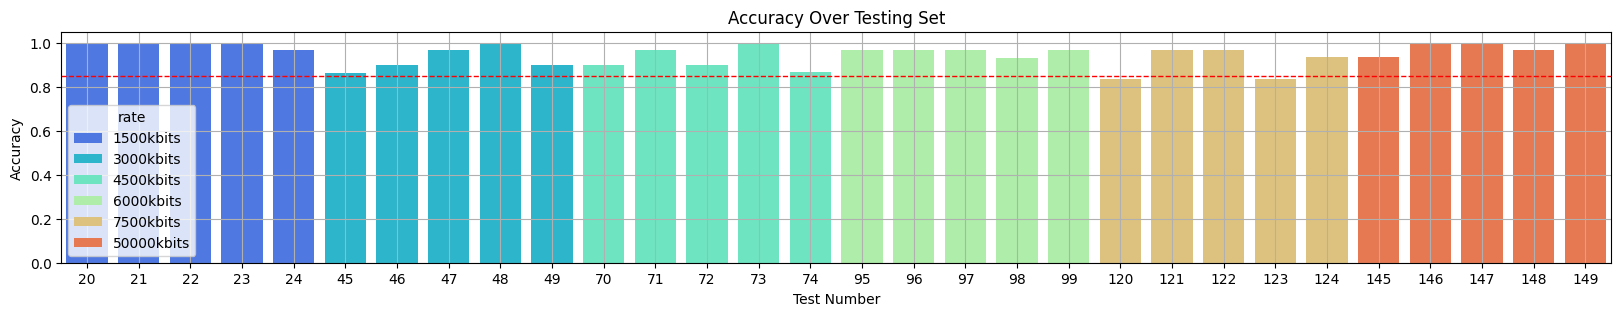

In [12]:
results = []

# Loop over each test
for test in testing_set:
    numb = test[TEST_NUMBER].iloc[0]
    rate = test[RATE].iloc[0]
    
    # Extract features and ground truth class
    x = test[tcp_features]
    y = test[GROUND_TRUTH_CLASS]
    
    # Test the model
    preds = best_model.predict(x)
    score = accuracy_score(y, preds)
    error = 1 - score
    
    # Append the results to the list
    results.append((numb, rate, score, error))

# Convert results to a DataFrame for easy plotting
statistics = pandas.DataFrame(results, columns=["test_number", "rate", "accuracy", "error"])

# Render the bar plot for accuracy
xaxis_title = "Test Number"
yaxis_title = "Accuracy"
chart_title = "Accuracy Over Testing Set"

plt.figure(figsize=(20, 3))
bar = seaborn.barplot(x="test_number", y="accuracy", hue="rate", data=statistics, palette="rainbow")
plt.title(chart_title)
plt.xlabel(xaxis_title)
plt.ylabel(yaxis_title)
plt.axhline(y=0.85, color="red", linestyle="--", linewidth=1)
plt.grid(True)
plt.show()


Top 5 Feature Importances (Sorted):
s_bytes_all          ->       0.96
c_bytes_all          ->       0.01
avg_span             ->       0.01
idle                 ->       0.01
c_bytes_all_#9       ->       0.00


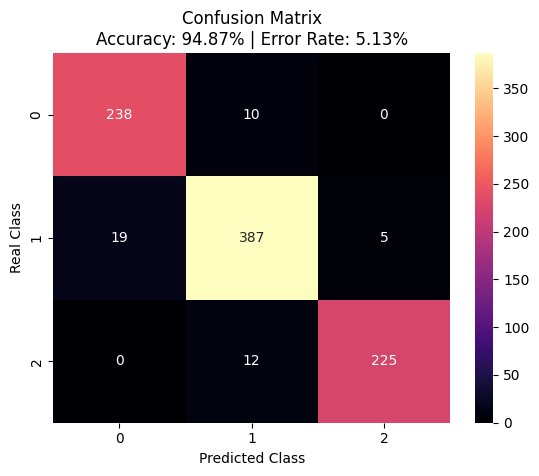

In [13]:
test = pandas.concat(testing_set, ignore_index=True)
# Test the performance over the testing set
x_test  = test[tcp_features]
y_test  = test[GROUND_TRUTH_CLASS]
    
# Test model
preds = best_model.predict(x_test)
score = accuracy_score(y_test, preds)

# Extract features and importance from the best model
classes              = best_model.classes_
features_importance  = list(best_model.feature_importances_)
features_names       = list(best_model.feature_names_in_)

# Compute the accuracy and the error rate
accuracy   = score
error_rate = 100 - accuracy * 100
accuracy   = accuracy * 100 

# Create confusion matrix
matrix = confusion_matrix(y_test, preds)

# Combine feature names and importance, then sort by importance in descending order
sorted_features = sorted(zip(features_names, features_importance), key=lambda x: x[1], reverse=True)

# Print the top 5 feature importances sorted by importance
print("\nTop 5 Feature Importances (Sorted):")
for feature, importance in sorted_features[:5]:
    print(f"{feature:<20} -> {importance:>10.2f}")

xaxis_title = "Predicted Class"
yaxis_title = "Real Class"
chart_title = f"Confusion Matrix\nAccuracy: {accuracy:.2f}% | Error Rate: {error_rate:.2f}%"

# Print the heatmap with the confusion matrix
seaborn.heatmap(matrix, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=classes)
plt.xlabel(xaxis_title)
plt.ylabel(yaxis_title)
plt.title(chart_title)
plt.show()

In [14]:
# # Select only test 121
# test_121 = test[test[TEST_NUMBER] == 122]

# # Plotting
# plt.figure(figsize=(20, 2))

# # Iterate through each row of the selected test and plot segments
# for idx, row in test_121.iterrows():
#     # Extract the start time (ts), end time (te), class, and ground truth
#     ts = row['ts']
#     te = row['te']
#     yg = row[GROUND_TRUTH_CLASS]
#     yp = row[PREDICTED_CLASS]
    
#     if yg != yp:
#         # Plot the ground truth segment (in green)
#         plt.plot([ts, te], [yg, yg], color='red',    lw=2, linestyle="--")
#         plt.plot([ts, te], [yp, yp], color='black',  lw=2)
#     else:
#         plt.plot([ts, te], [yp, yp], color='black',  lw=2)

# # Add labels and title
# plt.title(f'Segment Visualization for Test Number 121')
# plt.xlabel('Time')
# plt.ylabel('Class')

# plt.ylim(-0.5, 2.5)

# # Set x-ticks to a 1-second step
# min_time = test_121['ts'].min()
# max_time = test_121['te'].max()
# plt.xticks(range(int(min_time), int(max_time) + 1, 10 * 1000))
# plt.gca().set_xticklabels([str(i // 1000) for i in plt.gca().get_xticks()])

# # Add legend
# plt.legend()

# # Show the plot
# plt.grid(True)
# plt.show()

# # Plotting
# plt.figure(figsize=(20, 2))

# # Iterate through each row of the selected test and plot segments
# for idx, row in test_121.iterrows():
#     # Extract the start time (ts), end time (te), class, and ground truth
#     ts = row['ts']
#     te = row['te']
#     y  = row["s_bytes_all"]
#     plt.fill_between([ts, te], [0, 0], [y, y], color='gray', alpha=0.5)
#     plt.plot([ts, te], [y, y], color='black',  lw=2)

# # Add labels and title
# plt.title(f'Segment Visualization for Test Number 121')
# plt.xlabel('Time')
# plt.ylabel('Byte')

# # Set x-ticks to a 1-second step
# min_time = test_121['ts'].min()
# max_time = test_121['te'].max()
# plt.xticks(range(int(min_time), int(max_time) + 1, 10 * 1000))
# plt.gca().set_xticklabels([str(i // 1000) for i in plt.gca().get_xticks()])
# # Show the plot
# plt.grid(True)
# plt.show()